# Image pixel-level saliency using VGG-19 Conv-net

Lets have plots appear inline:

In [1]:
%matplotlib inline

We're going to need `numpy`, `matplotlib`, `skimage`, `theano` and `lasagne`. The `pretrained_vgg_models` contains some useful functions for building and acquiring VGG models.

In [2]:
import os, time
import numpy as np
from matplotlib import pyplot as plt
import theano
import lasagne
import skimage.transform, skimage.util
import pretrained_vgg_models

from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer, DropoutLayer, Pool2DLayer, Conv2DLayer, NINLayer
from lasagne.nonlinearities import softmax
from lasagne.utils import floatX


/Users/Geoff/packages/Theano/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


## Load an image to process

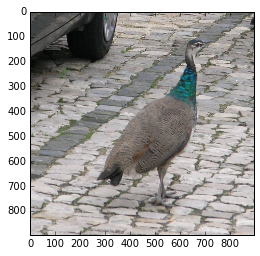

In [3]:
IMAGE_PATH = os.path.join('images', 'P1013781.JPG')
# Extract a 896 x 896 block surrounding the peacock
img = plt.imread(IMAGE_PATH)[1800:2696,652:1548]
plt.imshow(img)
plt.show()

## Load the model

To save some time, we are going to use the `VGG19Model` class from `pretrained_vgg_models` to build the network and load its parameters:

In [4]:
vgg19_model = pretrained_vgg_models.VGG19Model.load()

Create the input variable, generate the probability expression and construct a Theano function that we can call to predict image probability vectors:

In [5]:
in_var = theano.tensor.tensor4('x')
prob = lasagne.layers.get_output(vgg19_model.network['prob'], in_var, deterministic=True)
prob_fn = theano.function([in_var], prob)

Prepare the image, scaling to 224x224:

In [6]:
raw_img, img_for_vgg = vgg19_model.prepare_image(img, image_size=224)

## Discover the pixel-level image saliency
We will be using guided backpropagation [1] as described in, with the implementation taken from [2]:

[1]: Springenberg et al. (2015): "Striving for Simplicity - The All Convolutional Net", http://arxiv.org/abs/1412.6806
[2]: Jan Schlüter (@f0k), 2015-10-13: "Saliency Maps and Guided Backpropagation (Lasagne Recipe)", http://github.com/Lasagne/Recipes/blob/master/examples/Saliency%20Maps%20and%20Guided%20Backpropagation.ipynb

Please see the above references for more information on the technique and its implementation.

In [7]:
class ModifiedBackprop(object):
    def __init__(self, nonlinearity):
        self.nonlinearity = nonlinearity
        self.ops = {}  # memoizes an OpFromGraph instance per tensor type

    def __call__(self, x):
        # OpFromGraph is oblique to Theano optimizations, so we need to move
        # things to GPU ourselves if needed.
        if theano.sandbox.cuda.cuda_enabled:
            maybe_to_gpu = theano.sandbox.cuda.as_cuda_ndarray_variable
        else:
            maybe_to_gpu = lambda x: x
        # We move the input to GPU if needed.
        x = maybe_to_gpu(x)
        # We note the tensor type of the input variable to the nonlinearity
        # (mainly dimensionality and dtype); we need to create a fitting Op.
        tensor_type = x.type
        # If we did not create a suitable Op yet, this is the time to do so.
        if tensor_type not in self.ops:
            # For the graph, we create an input variable of the correct type:
            inp = tensor_type()
            # We pass it through the nonlinearity (and move to GPU if needed).
            outp = maybe_to_gpu(self.nonlinearity(inp))
            # Then we fix the forward expression...
            op = theano.OpFromGraph([inp], [outp])
            # ...and replace the gradient with our own (defined in a subclass).
            op.grad = self.grad
            # Finally, we memoize the new Op
            self.ops[tensor_type] = op
        # And apply the memoized Op to the input we got.
        return self.ops[tensor_type](x)
    
class GuidedBackprop(ModifiedBackprop):
    def grad(self, inputs, out_grads):
        (inp,) = inputs
        (grd,) = out_grads
        dtype = inp.dtype
        return (grd * (inp > 0).astype(dtype) * (grd > 0).astype(dtype),)
    
# Only instantiate this class once
GuidedBackprop.instance = GuidedBackprop(lasagne.nonlinearities.rectify)


def apply_guided_backprop(vgg_model):
    # We are going to be replacing the ReLU non-linearities
    relu = lasagne.nonlinearities.rectify
    # Get the layers from the network that use a ReLU non-linearity
    relu_layers = [layer for layer in lasagne.layers.get_all_layers(vgg_model.final_layer)
                   if getattr(layer, 'nonlinearity', None) is relu]
    # Replace the non-linearities
    for layer in relu_layers:
        layer.nonlinearity = GuidedBackprop.instance  
        
        
apply_guided_backprop(vgg19_model)
        

def compile_saliency_function(vgg_model, cls_index=None):
    """
    Compiles a function to compute the saliency maps and predicted classes
    for a given minibatch of input images.
    """
    # Input expression
    inp = vgg_model.network['input'].input_var
    # Output expression, before softmax
    outp = lasagne.layers.get_output(vgg_model.network['fc8'], deterministic=True)
    if cls_index is None:
        # No class specified; choose class with max probability
        cls_outp = T.max(outp, axis=1)
        cls_index = T.argmax(outp, axis=1)
    else:
        # Output with specified class
        cls_outp = outp[:,cls_index]
    # Saliency is gradient of output with respect to input
    saliency = theano.grad(cls_outp.sum(), wrt=inp)
    return theano.function([inp], saliency)

Predict probability for image and display it:

In [8]:
pred_prob = prob_fn(img_for_vgg)
pred_cls = np.argmax(pred_prob, axis=1)[0]
print('pred_prob.shape={}, pred_cls={}'.format(pred_prob.shape, pred_cls))

pred_prob.shape=(1, 1000), pred_cls=84


Compile a saliency function:

In [9]:
saliency_fn = compile_saliency_function(vgg19_model, 84)

Compute a saliency image as a tensor:

In [10]:
saliency = saliency_fn(img_for_vgg)

Plot it:

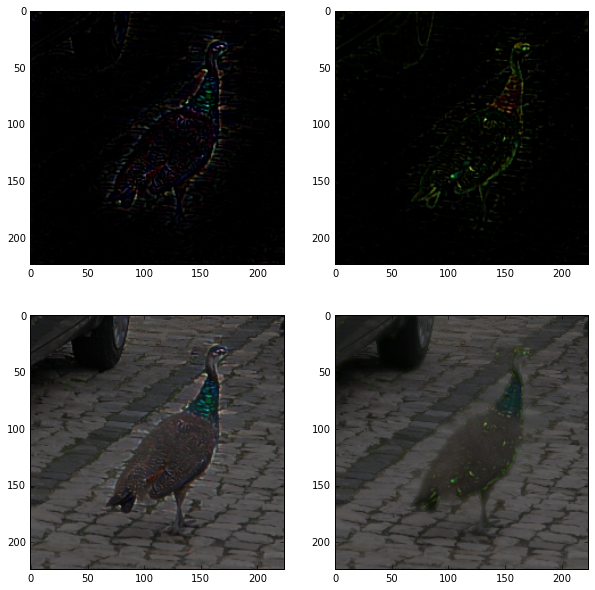

In [11]:
# Extract sample 0, move channel axis to the back and swap BGR to RGb
saliency_image = saliency[0][::-1].transpose(1, 2, 0)

# Plot
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(np.maximum(saliency_image, 0.0) / saliency_image.max())

plt.subplot(2,2,2)
plt.imshow(np.maximum(-saliency_image, 0.0) / -saliency_image.min())

plt.subplot(2,2,3)
plt.imshow(raw_img)
plt.imshow(np.maximum(saliency_image, 0.0) / saliency_image.max(), alpha=0.6)

plt.subplot(2,2,4)
plt.imshow(raw_img)
plt.imshow(np.maximum(-saliency_image, 0.0) / -saliency_image.min(), alpha=0.6)
plt.show()